In [121]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np

In [122]:
!pwd

/Users/walml/repos/zoobot/notebooks


In [123]:
df = pd.read_csv('../data/ring_tag_catalog_all.csv')  # "all" in the sense it includes tags for galaxies with no tags, 250k

In [124]:
# a little personal path fiddling - you'll want to change this
df['local_png_loc'] = df['local_png_loc'].str.replace('/media/walml/beta1', '/Volumes/beta')

In [125]:
len(df)

253286

In [21]:
rings = df.query('tag_count > 0').reset_index()
len(rings)

2642

In [13]:
morph_cols = [
    'smooth-or-featured_featured-or-disk_fraction',
    'disk-edge-on_no_fraction',
    'has-spiral-arms_no_fraction'
]

In [55]:
# preds_loc = '/home/walml/repos/zoobot_private/gz_decals_auto_posteriors.parquet'
preds_loc = '/Users/walml/repos/zoobot_private/gz_decals_auto_posteriors.parquet'
preds = pd.read_parquet(preds_loc, columns=morph_cols+['iauname'])

In [59]:
ring_preds = pd.merge(rings, preds, on='iauname', how='inner')
assert len(ring_preds) == len(rings)

In [60]:
ring_preds['smooth-or-featured_featured-or-disk_fraction']

0       0.896704
1       0.341311
2       0.768587
3       0.722452
4       0.641906
          ...   
2637    0.605217
2638    0.452941
2639    0.651499
2640    0.888195
2641    0.526259
Name: smooth-or-featured_featured-or-disk_fraction, Length: 2642, dtype: float64

<AxesSubplot:>

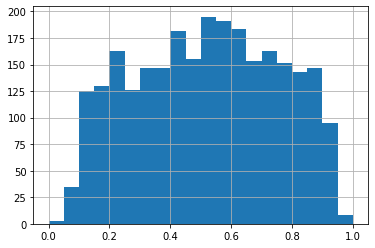

In [61]:
ring_preds['smooth-or-featured_featured-or-disk_fraction'].hist(bins=20, range=(0, 1))

In [69]:
def show_galaxies(df, start_index=0, crop_size=50):
    fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(12, 5))
    all_axes = [ax for row in axes for ax in row]
    for n in range(10):
        galaxy = df.iloc[start_index+n]
        im = Image.open(galaxy['local_png_loc']).crop((50, 50, 424-crop_size, 424-crop_size))
        ax = all_axes[n]
        ax.imshow(im)
        ax.axis(False)
        ax.text(30, 30, 'R. Tags: {:.0f}'.format(galaxy['tag_count']), color='r')
        ax.text(30, 60, 'Feat: {:.2f}'.format(galaxy['smooth-or-featured_featured-or-disk_fraction']), color='r')
        ax.text(30, 90, 'Edge: {:.2f}'.format(1-galaxy['disk-edge-on_no_fraction']), color='r')
    fig.tight_layout()

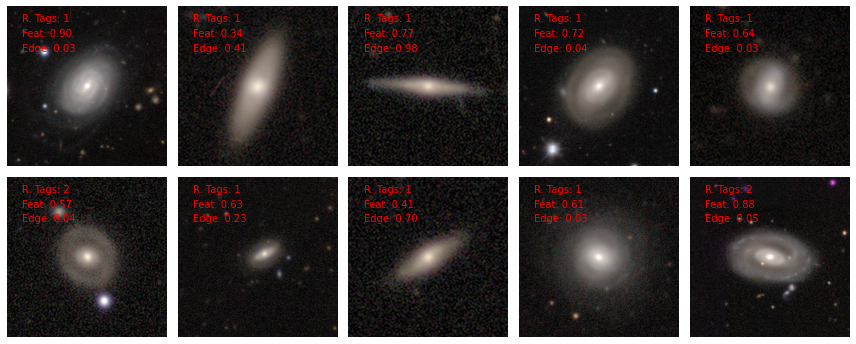

In [70]:
show_galaxies(ring_preds)

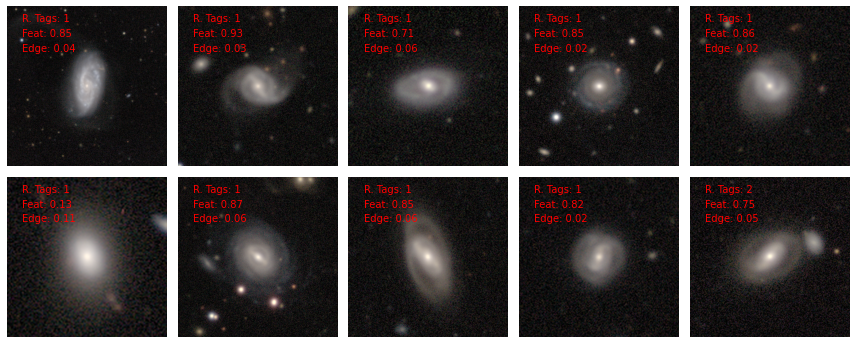

In [72]:
show_galaxies(ring_preds, 10)

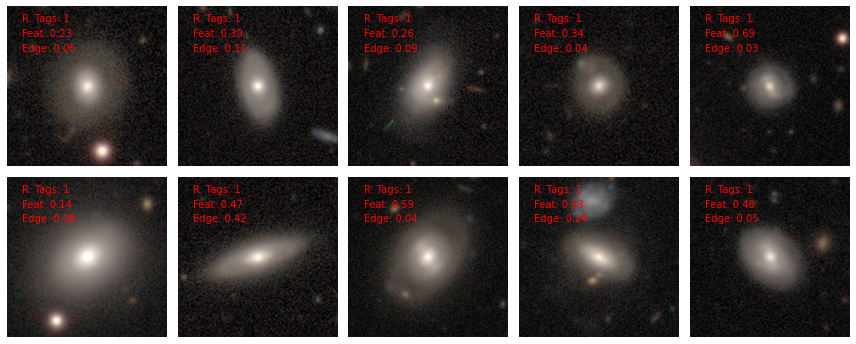

In [73]:
show_galaxies(ring_preds, 20)

In [112]:
very_smooth = ring_preds[ring_preds['smooth-or-featured_featured-or-disk_fraction'] < 0.15].reset_index(drop=True)
quite_smooth = ring_preds[(ring_preds['smooth-or-featured_featured-or-disk_fraction'] > 0.15) & (ring_preds['smooth-or-featured_featured-or-disk_fraction'] < 0.25)].reset_index(drop=True)
not_that_smooth = ring_preds[(ring_preds['smooth-or-featured_featured-or-disk_fraction'] > 0.25) & (ring_preds['smooth-or-featured_featured-or-disk_fraction'] < 0.6)].reset_index(drop=True)
not_that_smooth_face = not_that_smooth[not_that_smooth['disk-edge-on_no_fraction'] > 0.75].reset_index(drop=True)  # bit dodgy as not asked for truly smooth

smooth = ring_preds[ring_preds['smooth-or-featured_featured-or-disk_fraction'] < 0.4].reset_index(drop=True)
feat = ring_preds[ring_preds['smooth-or-featured_featured-or-disk_fraction'] > 0.6].reset_index(drop=True)
feat_face = feat[feat['disk-edge-on_no_fraction'] > 0.75].reset_index(drop=True)
not_spiral = feat_face[feat_face['has-spiral-arms_no_fraction'] > 0.5].reset_index(drop=True)

In [106]:
print(len(very_smooth), len(quite_smooth),  len(not_that_smooth), len(smooth), len(feat), len(feat_face), len(not_spiral))

163 293 1143 876 1043 996 235


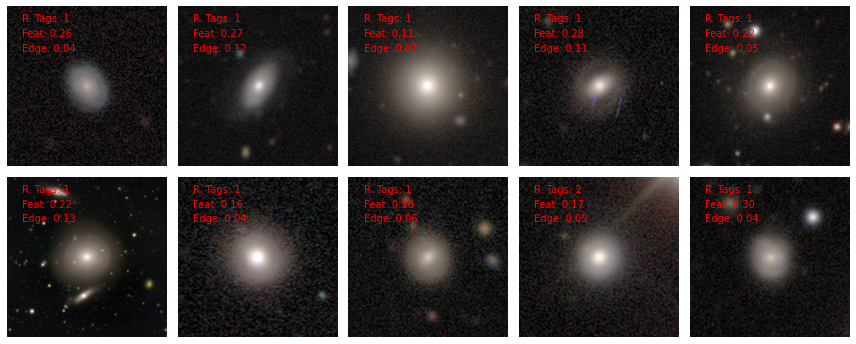

In [110]:
show_galaxies(smooth.sample(10))  # smooth is not a great ring selection - about half are rings, mostly featured > 0.3ish

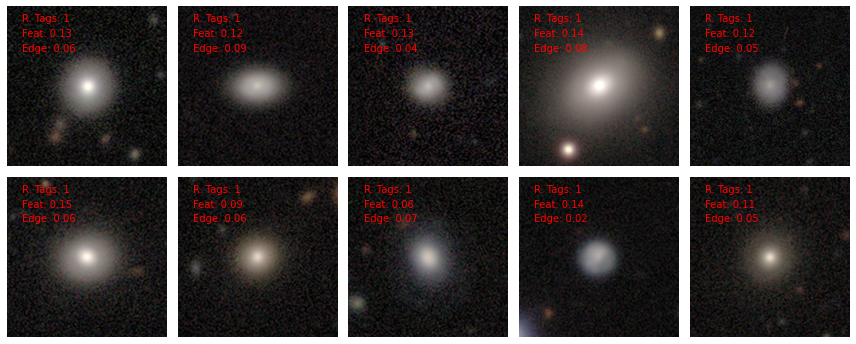

In [103]:
show_galaxies(very_smooth.sample(10))  # very smooth are <20% rings

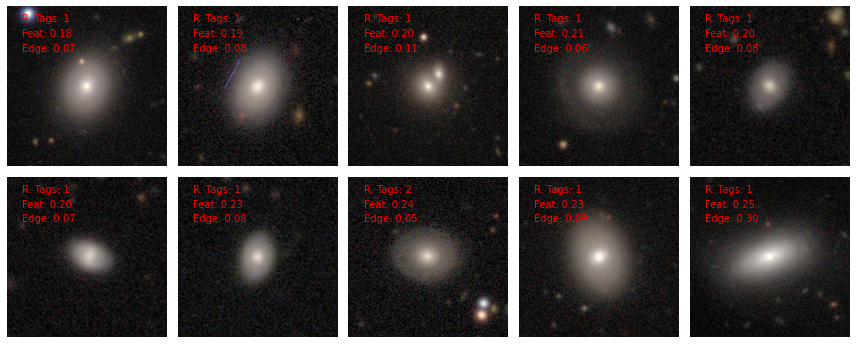

In [104]:
show_galaxies(quite_smooth.sample(10))  # quite smooth are ~35% rings

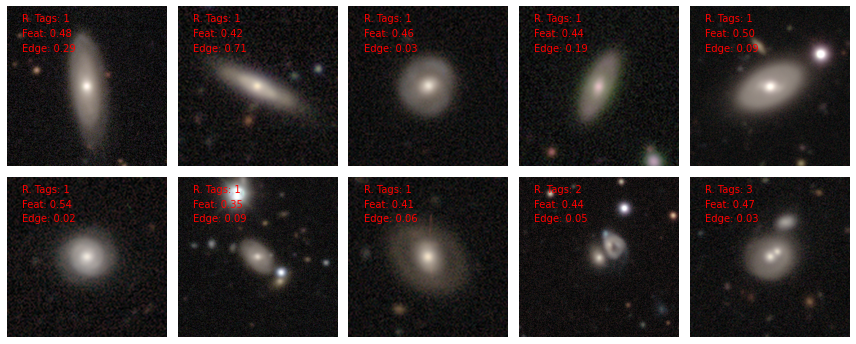

In [109]:
show_galaxies(not_that_smooth.sample(10))  # not that smooth (0.25-0.6) are ~70% rings, and most of the smooth galaxies. So 0.25 seems a pretty good cut

In [116]:
# not_that_smooth['disk-edge-on_no_fraction'].hist(bins=20, range=(0, 1))

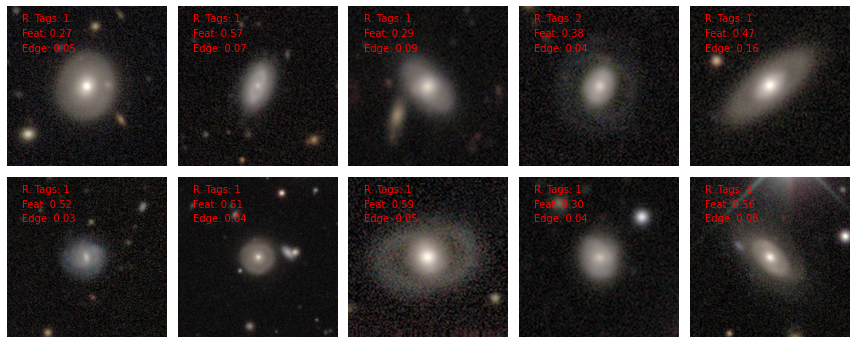

In [114]:
show_galaxies(not_that_smooth_face.sample(10))  # vast majority are voted face-on, drop a few edge-on examples

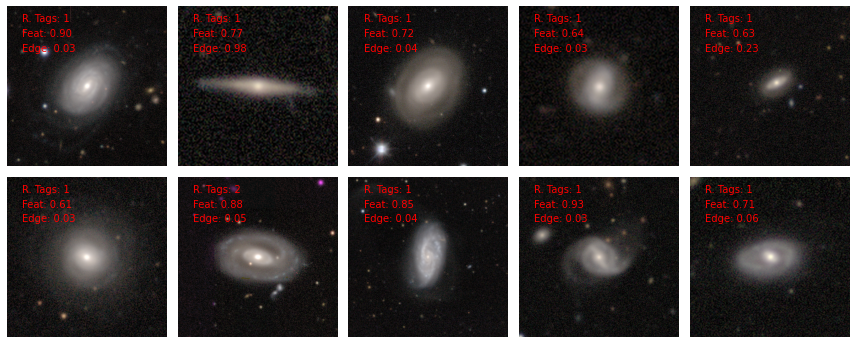

In [78]:
show_galaxies(feat.sample(10)) # might as well remove edge-on straight away...

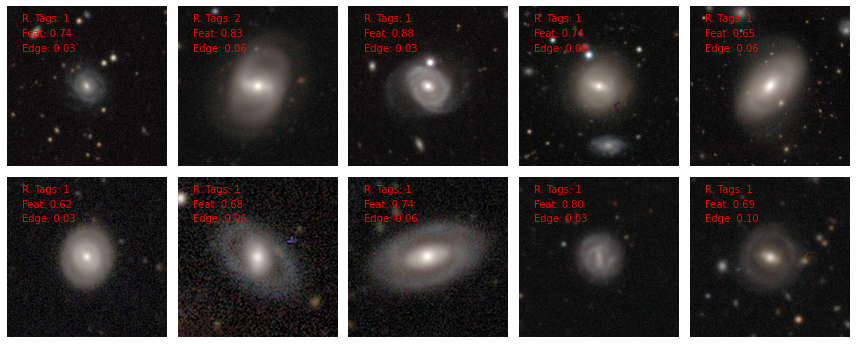

In [119]:
show_galaxies(feat_face.sample(10))  # about half are (lovely) big rings, the other half are spirals with nuclear rings

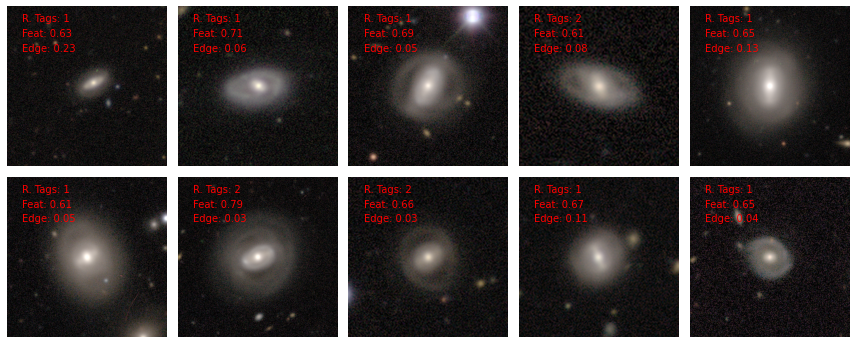

In [81]:
show_galaxies(not_spiral)  # good selection but only ~200 - and pseudorings are also of interest

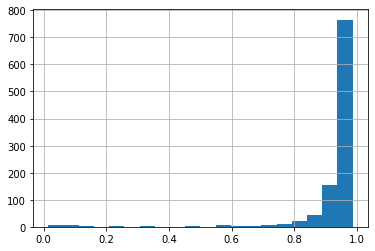

In [125]:
feat['disk-edge-on_no_fraction'].hist(bins=20)

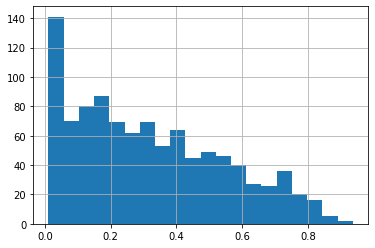

In [129]:
feat_face['has-spiral-arms_no_fraction'].hist(bins=20)

In [119]:
len(not_spiral)

143

In [120]:
not_spiral.iloc[102]

iauname                                                                            J141545.94+102619.8
tag_count                                                                                            1
local_png_loc                                        /media/walml/beta1/decals/png_native/dr5/J141/...
smooth-or-featured_smooth_concentration              [16.9, 18.7129, 21.6262, 19.9226, 20.5558, 28....
smooth-or-featured_featured-or-disk_concentration    [53.5227, 47.2262, 53.2994, 48.47, 55.2235, 52...
                                                                           ...                        
edge-on-bulge_proportion_volunteers_asked                                                    0.0526541
spiral-winding_proportion_volunteers_asked                                                    0.182271
spiral-arm-count_proportion_volunteers_asked                                                  0.182271
merging_proportion_volunteers_asked                                      

In [121]:
not_spiral.iloc[103]

iauname                                                                            J141857.36+002156.1
tag_count                                                                                            1
local_png_loc                                        /media/walml/beta1/decals/png_native/dr5/J141/...
smooth-or-featured_smooth_concentration              [30.7865, 30.4856, 27.8025, 32.5492, 39.2576, ...
smooth-or-featured_featured-or-disk_concentration    [49.1435, 40.2586, 51.2672, 43.1614, 53.7604, ...
                                                                           ...                        
edge-on-bulge_proportion_volunteers_asked                                                    0.0198452
spiral-winding_proportion_volunteers_asked                                                    0.201977
spiral-arm-count_proportion_volunteers_asked                                                  0.201977
merging_proportion_volunteers_asked                                      

In [122]:
not_spiral.iloc[102]['local_png_loc'], not_spiral.iloc[103]['local_png_loc']

('/media/walml/beta1/decals/png_native/dr5/J141/J141545.94+102619.8.png',
 '/media/walml/beta1/decals/png_native/dr5/J141/J141857.36+002156.1.png')

In [141]:
ring_catalog_with_morph = pd.merge(df, preds, how='inner', on='iauname')

In [145]:
ring_catalog_with_morph['ring'] = (ring_catalog_with_morph['tag_count'] > 0).astype(int)

In [146]:
ring_catalog_with_morph

iauname  tag_count  \
0       J000035.60-014547.0        1.0   
1       J000039.31-000048.2        1.0   
2       J000127.32+141126.9        1.0   
3       J000221.59+040522.9        1.0   
4       J000251.60+000800.7        1.0   
...                     ...        ...   
253281  J144017.17+234347.3        0.0   
253282  J133751.46+253954.0        0.0   
253283  J130734.26+061155.7        0.0   
253284  J163830.70+315116.7        0.0   
253285  J141631.85+185904.1        0.0   

                                            local_png_loc  \
0       /media/walml/beta1/decals/png_native/dr5/J000/...   
1       /media/walml/beta1/decals/png_native/dr5/J000/...   
2       /media/walml/beta1/decals/png_native/dr5/J000/...   
3       /media/walml/beta1/decals/png_native/dr5/J000/...   
4       /media/walml/beta1/decals/png_native/dr5/J000/...   
...                                                   ...   
253281  /media/walml/beta1/decals/png_native/dr5/J144/...   
253282  /media/walml/beta1/decals/png_native/dr5/J133/...   
253283  /media/walml/beta1/decals/png_native/dr5/J130/...   
253284  /media/walml/beta1/decals/png_native/dr5/J163/...   
253285  /media/walml/beta1/decals/png_native/dr5/J141/...   

        smooth-or-featured_featured-or-disk_fraction  \
0                                           0.896704   
1                                           0.341311   
2                                           0.768587   
3                                           0.722452   
4                                           0.641906   
...                                              ...   
253281                                      0.081090   
253282                                      0.188672   
253283                                      0.097921   
253284                                      0.095984   
253285                                      0.073585   

        disk-edge-on_no_fraction  has-spiral-arms_no_fraction  ring  
0                       0.969745                     0.032284     1  
1                       0.587562                     0.878487     1  
2                       0.017421                     0.780782     1  
3                       0.955182                     0.354890     1  
4                       0.974764                     0.285697     1  
...                          ...                          ...   ...  
253281                  0.936089                     0.968052     0  
253282                  0.389236                     0.912858     0  
253283                  0.926792                     0.965271     0  
253284                  0.726577                     0.676130     0  
253285                  0.672870                     0.766867     0  

[253286 rows x 7 columns]

In [147]:
# ring_catalog_with_morph.to_csv('../data/ring_catalog_with_morph.csv', index=False)